In [1]:
import kagglehub

path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

100%|██████████| 11.1M/11.1M [00:01<00:00, 7.15MB/s]

Extracting files...


Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from collections import Counter

In [ ]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [4]:
df = df.dropna()

In [ ]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


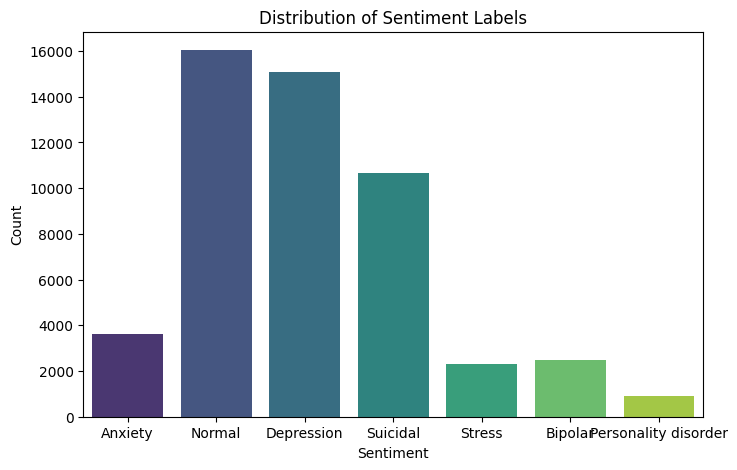

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

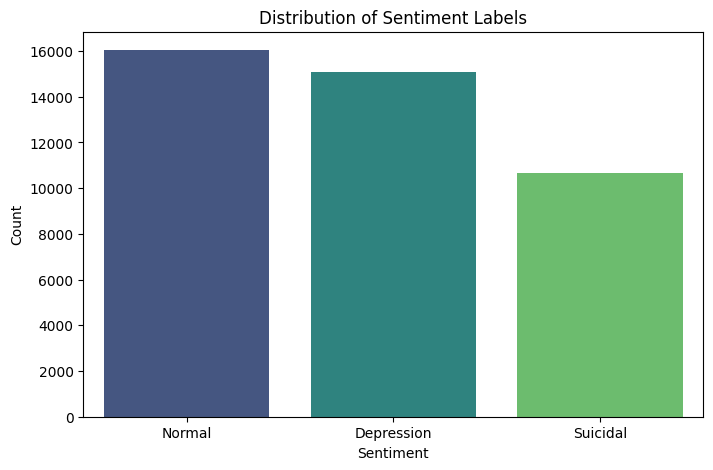

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
def manual_analysis(df, text_col="statement", label_col="status"):
    statuses = df[label_col].unique()

    for status in statuses:
        print(f"{status.upper()}")
        print("=" * 80)

        samples = df[df[label_col] == status][text_col].sample(2).values

        for i, text in enumerate(samples, 1):
            print(f"[{i}] {text}")
            print("-" * 80)
        print("\n")


manual_analysis(df)

NORMAL
[1] The penis is still early in the morning
--------------------------------------------------------------------------------
[2] Ptn! If you register for m4nd1r1 unpad, can you choose two or two (scheme 1&2 )?
--------------------------------------------------------------------------------


DEPRESSION
[1] I did it. I overdosed. I will take some more tomorrow morning I am overdosing
--------------------------------------------------------------------------------
[2] i want to end it so badly now everything in my life is pain if it is not my own mind tearing me to piece it is how people treat me and people like me i can t take this life i have no real friend i am a stranger to my family i work so hard to eek out some sort of life but all i have is a dinky apartment that i don t leave very often because i can t afford to do anything i fucking hate my existence every day stupid shit happens that have greater consequence example i wa getting in bed and my knee bumped my nightstand w

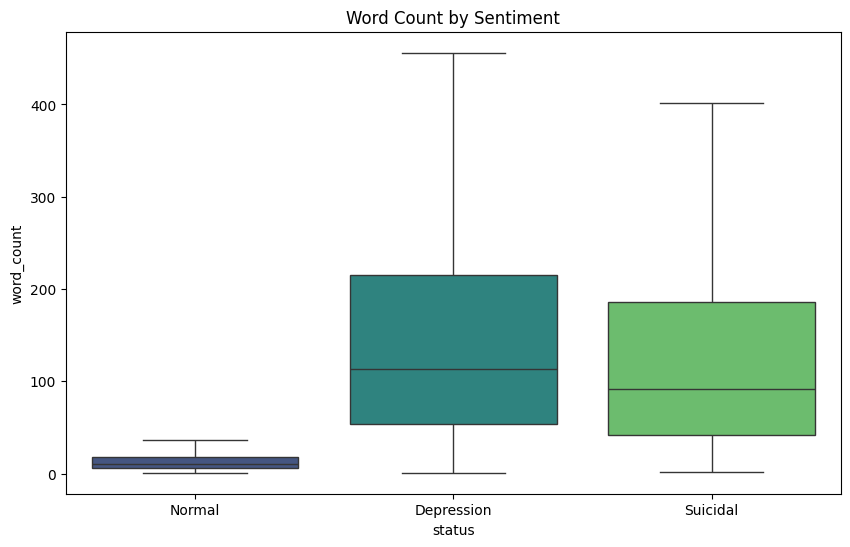

In [ ]:
df["word_count"] = df["statement"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="status",
    y="word_count",
    data=df,
    hue="status",
    palette="viridis",
    legend=False,
    showfliers=False,
)
plt.title("Word Count by Sentiment")
plt.show()

In [ ]:
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.encode("ascii", "ignore").decode()

    text = re.sub(r"https?:\/\/\S+|www\.\S+", "", text)  # Removes URL
    text = re.sub(r"@\w+", "", text)  # Removes "@Username"

    text = text.lower()  # Lowercase

    # \w+(?:'\w+)? -> Matches words and contractions (don't, i'm)
    # [^\w\s]+     -> Matches clusters of punctuation (??, ..., !!!)
    pattern = r"\w+(?:'\w+)?|[^\w\s]+"

    tokens = re.findall(pattern, text)

    clean_tokens = []
    for t in tokens:
        if re.match(r"\w+", t):
            clean_tokens.append(lemmatizer.lemmatize(t))
        else:
            clean_tokens.append(t)

    return " ".join(clean_tokens)


df["statement_processed"] = df["statement"].apply([preprocess])

[nltk_data] Downloading package wordnet to /home/banhcam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def filter_noise(df, text_col="statement_processed", label_col="status", threshold=0.9):
    unique_statuses = df[label_col].unique()
    status_word_ratios = {}
    all_vocab = set()

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]
        total_docs = len(subset)

        if total_docs == 0:
            continue

        word_doc_counts = Counter()
        for text in subset:
            words = set(re.findall(r"\b\w+\b", str(text).lower()))
            word_doc_counts.update(words)
            all_vocab.update(words)

        status_word_ratios[status] = {
            word: count / total_docs for word, count in word_doc_counts.items()
        }

    common_words = []
    for word in all_vocab:
        is_noise = True
        for status in unique_statuses:
            if status_word_ratios[status].get(word, 0) < threshold:
                is_noise = False
                break

        if is_noise:
            common_words.append(word)

    return sorted(common_words)


global_noise = filter_noise(df, threshold=0.8)
print(global_noise)

[]


In [ ]:
def top_words_per_class(
    df, text_col="statement_processed", label_col="status", top_k=20
):
    unique_statuses = df[label_col].unique()

    top_words_dict = {}

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]

        vec = CountVectorizer(ngram_range=(1, 1)).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        top_words_dict[status] = [word for word, freq in words_freq]

    comparison_df = pd.DataFrame(top_words_dict)
    return comparison_df


top_words_df = top_words_per_class(df)
print(top_words_df)

   Normal Depression Suicidal
0      to         to       to
1     the        and      and
2     and        the       my
3      it         my      the
4     you         it      not
5      is        not       it
6      my         of       am
7      of         me       is
8    that         is       me
9      in       have     have
10    for         am       of
11   have       that       do
12     me         do     that
13    but         in       in
14     wa        but      but
15     be        for     just
16   this       just      for
17   with       this     this
18     on         so       so
19     so       with     want


In [ ]:
custom_stop_words = [
    "to",
    "the",
    "and",
    "of",
    "in",
    "for",
    "with",
    "on",
    "that",
    "this",
    "it",
    "is",
    "be",
    "wa",
    "so",
    "but",
    "or",
    "as",
    "at",
    "by",
]


def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in custom_stop_words]
    return " ".join(filtered_tokens)


df["statement_processed"] = df["statement_processed"].apply(remove_stop_words)

print(df[["status", "statement_processed"]].head())

   status                                statement_processed
0  Normal              gr gr dreaming ex crush my game , god
1  Normal                                 wkwkwk what a joke
2  Normal  leaf are also standby front pc ... because off...
3  Normal     thank god even though it's just a ride through
4  Normal  wedding teaser concept using song day6 - only ...


In [ ]:
def ngram_comparison(df, status_label, text_col="statement_processed", top_k=10):
    subset = df[df["status"] == status_label][text_col]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    n_ranges = [(1, 1), (2, 2), (3, 3)]
    titles = ["Unigrams", "Bigrams", "Trigrams"]
    colors = ["#4A90E2", "#50E3C2", "#F5A623"]

    for i, (n_range, title, color) in enumerate(zip(n_ranges, titles, colors)):
        vec = CountVectorizer(ngram_range=n_range, stop_words=None).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        if words_freq:
            words, counts = zip(*words_freq)
            sns.barplot(x=list(counts), y=list(words), ax=axes[i], color=color)
            axes[i].set_title(f"{status_label.upper()}: {title}")
            axes[i].set_xlabel("Frequency")

    plt.show()

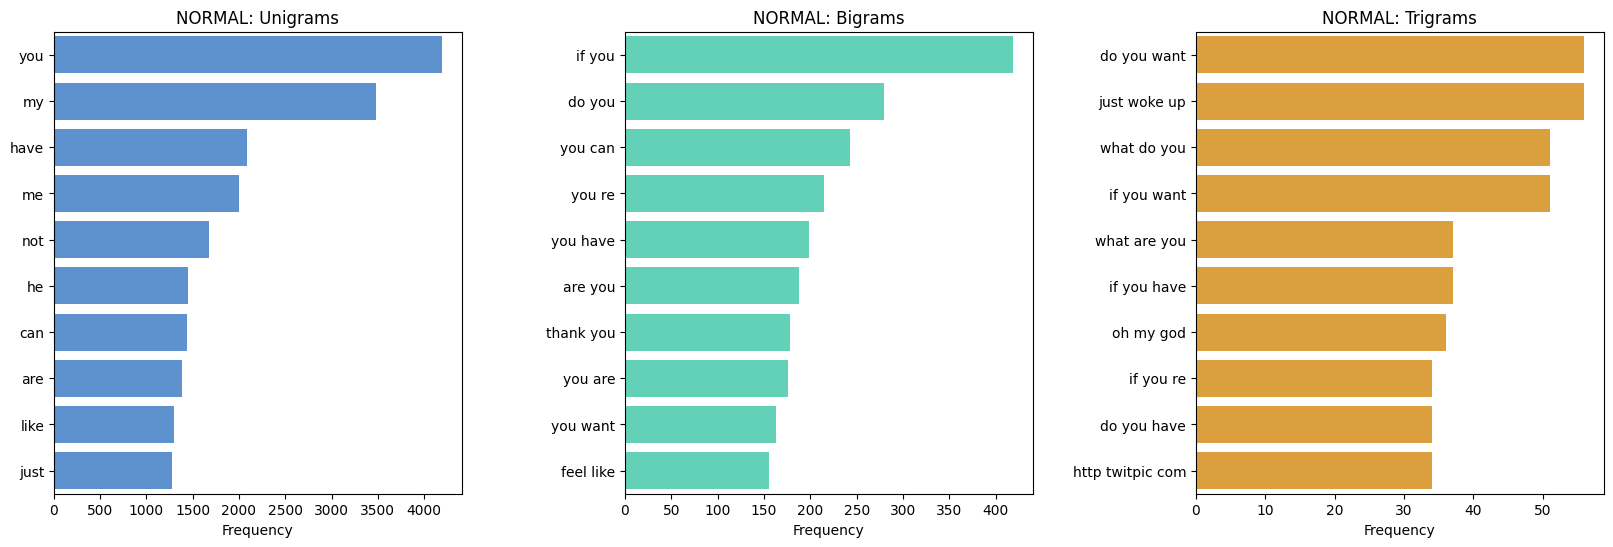

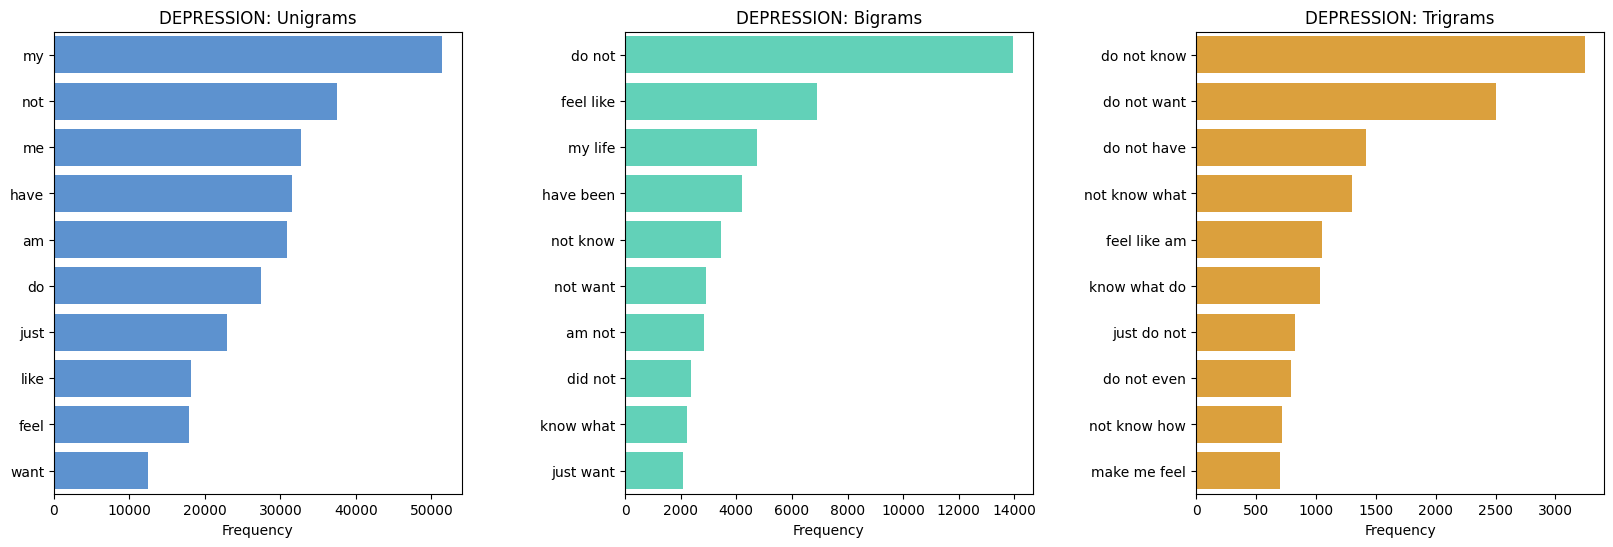

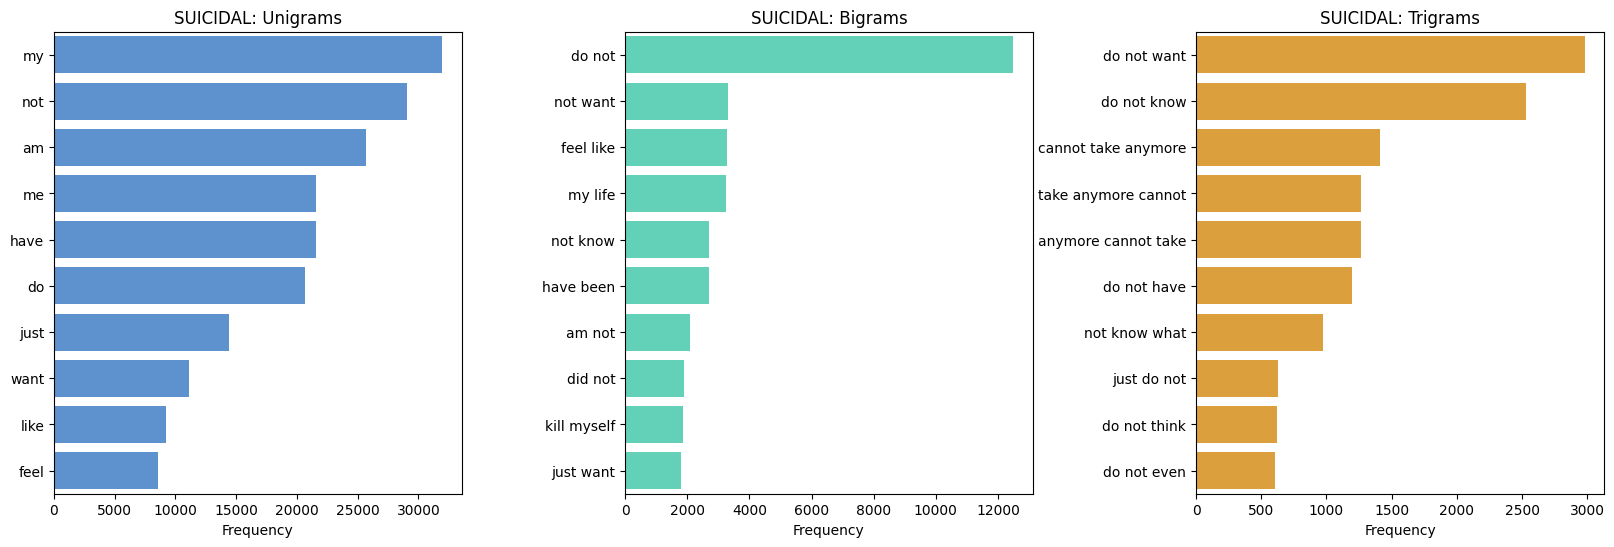

In [ ]:
ngram_comparison(df, status_label="Normal")
ngram_comparison(df, status_label="Depression")
ngram_comparison(df, status_label="Suicidal")

In [ ]:
X = df["statement_processed"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
def lr_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    solver = trial.suggest_categorical("lr__solver", ["lbfgs", "saga"])
    C = trial.suggest_float("lr__C", 0.1, 10, log=True)

    penalty = "l2"
    if solver == "saga":
        penalty = trial.suggest_categorical("lr__penalty", ["l1", "l2"])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "lr",
                LogisticRegression(
                    max_iter=5000,
                    solver=solver,
                    penalty=penalty,
                    C=C,
                    class_weight="balanced",
                    random_state=42,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [ ]:
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lr_objective, n_trials=50)

print(f"Best LR Score: {study_lr.best_value}")
print(f"Best LR Params :{study_lr.best_params}")

[I 2025-12-31 17:26:08,923] A new study created in memory with name: no-name-1a459acc-d840-4336-bf5e-3145d93baf82
[I 2025-12-31 17:27:13,978] Trial 0 finished with value: 0.7632339443080615 and parameters: {'tfidf__max_features': 15500, 'tfidf__max_df': 0.920555171386839, 'tfidf__min_df': 4, 'lr__solver': 'saga', 'lr__C': 0.1289029582307158, 'lr__penalty': 'l1'}. Best is trial 0 with value: 0.7632339443080615.
[I 2025-12-31 17:27:31,694] Trial 1 finished with value: 0.7973353185255184 and parameters: {'tfidf__max_features': 16500, 'tfidf__max_df': 0.8511824211884743, 'tfidf__min_df': 7, 'lr__solver': 'lbfgs', 'lr__C': 4.637004403945946}. Best is trial 1 with value: 0.7973353185255184.
[I 2025-12-31 17:28:33,148] Trial 2 finished with value: 0.8035877168863145 and parameters: {'tfidf__max_features': 12500, 'tfidf__max_df': 0.8693973841868659, 'tfidf__min_df': 3, 'lr__solver': 'saga', 'lr__C': 0.9224614702519637, 'lr__penalty': 'l1'}. Best is trial 2 with value: 0.8035877168863145.
[I 20

Best LR Score: 0.8069712467196446
Best LR Params :{'tfidf__max_features': 11500, 'tfidf__max_df': 0.8426959373094656, 'tfidf__min_df': 5, 'lr__solver': 'lbfgs', 'lr__C': 1.0343086751539978}


In [ ]:
def svc_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    C = trial.suggest_float("svc__C", 0.01, 10, log=True)

    penalty = trial.suggest_categorical("svc__penalty", ["l1", "l2"])

    if penalty == "l1":
        loss = "squared_hinge"
        dual = False
    else:
        loss = trial.suggest_categorical("svc__loss", ["hinge", "squared_hinge"])
        dual = False if loss == "squared_hinge" else True

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "svc",
                LinearSVC(
                    C=C,
                    penalty=penalty,
                    loss=loss,
                    dual=dual,
                    class_weight="balanced",
                    max_iter=5000,
                    random_state=42,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [ ]:
study_svc = optuna.create_study(direction="maximize")
study_svc.optimize(svc_objective, n_trials=50)

print(f"Best SVC Score: {study_svc.best_value}")
print(f"Best SVC Params :{study_svc.best_params}")

[I 2025-12-31 17:40:50,362] A new study created in memory with name: no-name-a74700f2-ca0a-4a11-a7d9-3af82341d662
[I 2025-12-31 17:41:07,510] Trial 0 finished with value: 0.7962415424440156 and parameters: {'tfidf__max_features': 12000, 'tfidf__max_df': 0.8028249836429862, 'tfidf__min_df': 4, 'svc__C': 0.9035744742572549, 'svc__penalty': 'l2', 'svc__loss': 'squared_hinge'}. Best is trial 0 with value: 0.7962415424440156.
[I 2025-12-31 17:41:33,315] Trial 1 finished with value: 0.78942233962691 and parameters: {'tfidf__max_features': 15000, 'tfidf__max_df': 0.935138385016218, 'tfidf__min_df': 6, 'svc__C': 1.4426424685541728, 'svc__penalty': 'l1'}. Best is trial 0 with value: 0.7962415424440156.
[I 2025-12-31 17:42:02,774] Trial 2 finished with value: 0.7849108094945465 and parameters: {'tfidf__max_features': 14500, 'tfidf__max_df': 0.8302534299202725, 'tfidf__min_df': 2, 'svc__C': 4.9911774676068505, 'svc__penalty': 'l2', 'svc__loss': 'hinge'}. Best is trial 0 with value: 0.796241542444

Best SVC Score: 0.8077140491155299
Best SVC Params :{'tfidf__max_features': 12500, 'tfidf__max_df': 0.8373095607730205, 'tfidf__min_df': 7, 'svc__C': 0.8929814856964768, 'svc__penalty': 'l2', 'svc__loss': 'hinge'}


In [ ]:
joblib.dump(study_lr, "./study_lr.pkl")
joblib.dump(study_svc, "./study_svc.pkl")

['./study_svc.pkl']

In [ ]:
lr_params = study_lr.best_params

lr_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=lr_params["tfidf__max_features"],
                max_df=lr_params["tfidf__max_df"],
                min_df=lr_params["tfidf__min_df"],
            ),
        ),
        (
            "lr",
            LogisticRegression(
                max_iter=5000,
                solver=lr_params["lr__solver"],
                penalty=lr_params.get("lr__penalty", "l2"),
                C=lr_params["lr__C"],
                class_weight="balanced",
                random_state=42,
            ),
        ),
    ]
)
lr_pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
svc_params = study_svc.best_params

svc_penalty = svc_params["svc__penalty"]
if svc_penalty == "l1":
    svc_loss = "squared_hinge"
    svc_dual = False
else:
    svc_loss = svc_params["svc__loss"]
    svc_dual = False if svc_loss == "squared_hinge" else True

svc_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=svc_params["tfidf__max_features"],
                max_df=svc_params["tfidf__max_df"],
                min_df=svc_params["tfidf__min_df"],
            ),
        ),
        (
            "svc",
            LinearSVC(
                C=svc_params["svc__C"],
                penalty=svc_penalty,
                loss=svc_loss,
                dual=svc_dual,
                class_weight="balanced",
                max_iter=5000,
                random_state=42,
            ),
        ),
    ]
)
svc_pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
joblib.dump(lr_pipeline, "./lr_pipeline.pkl")
joblib.dump(svc_pipeline, "./svc_pipeline.pkl")

['./svc_pipeline.pkl']

              precision    recall  f1-score   support

  Depression       0.82      0.72      0.76      3018
      Normal       0.92      0.96      0.94      3208
    Suicidal       0.68      0.75      0.71      2128

    accuracy                           0.82      8354
   macro avg       0.81      0.81      0.81      8354
weighted avg       0.82      0.82      0.82      8354



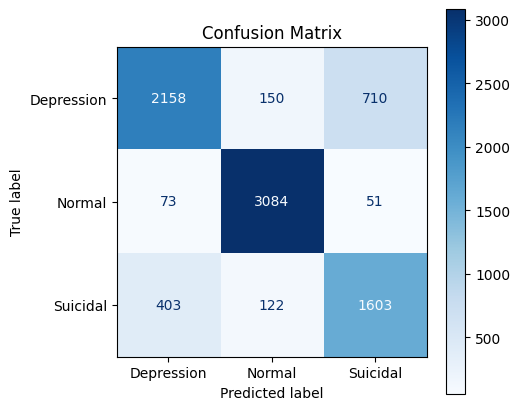

In [ ]:
y_pred_lr = lr_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lr))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

  Depression       0.82      0.74      0.78      3018
      Normal       0.91      0.97      0.94      3208
    Suicidal       0.70      0.73      0.71      2128

    accuracy                           0.82      8354
   macro avg       0.81      0.81      0.81      8354
weighted avg       0.82      0.82      0.82      8354



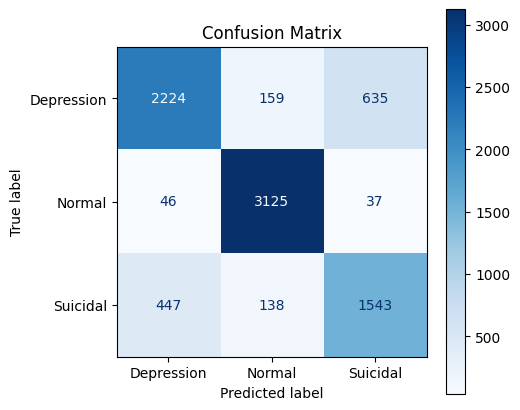

In [ ]:
y_pred_svc = svc_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svc))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()


 CLASS: Depression

[CORRECT PREDICTION] Random Text snippet: lady responsible my first experience being choked broke an ankle getting tossed out back door my underwear 9 because i called my mom a demon i knew nine she s a fucking beast who fed me her partner who a beast a fucking pedo now she s faux spiritual journey which includes putting loving herself first like after year breaking mirror your fist when i shoving me down stair ripping out my hair beating me until my ankle broke trying run free all past now i m i have move no closure you expect me just goofy smile s my new purpose she birthed me a freaking body bag she discarded me too s just surreal realize you were born purpose love follow one who had a kid because she needed a friend now she doesn t need me now i feel like i also have no purpose maybe i never did first place i girl took abuse silently now my role done what do i do myself now then why am i here if no one need me anymore...


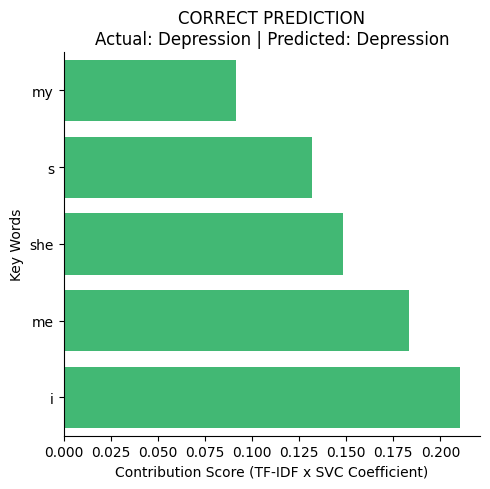


[WRONG PREDICTION] Random Text snippet: i feel like sometimes would easier just end . not have worry about anything . sad...


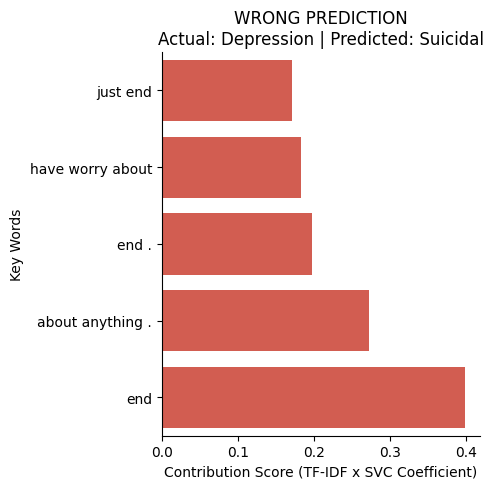


 CLASS: Normal

[CORRECT PREDICTION] Random Text snippet: there same ?...


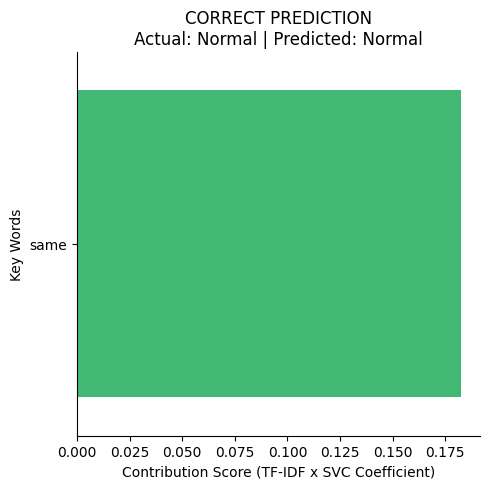


[WRONG PREDICTION] Random Text snippet: background : paul i met 1 . 5 year ago okcupid hit off right away . time , we were both long - term open relationship other people , we fell into a pretty quick routine involved seeing each other once a week a meal drink sex [ best his life , allegedly ]. about 6 month into / december before last , he his partner 8 year broke up , which sent him into a bit a depression / naturally intense period introspection . independently / unrelated reason , my own longterm relationship also came an end . paul i saw each other less kept touch ....


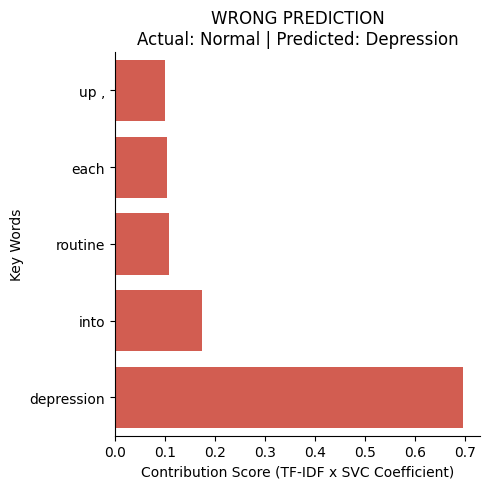


 CLASS: Suicidal

[CORRECT PREDICTION] Random Text snippet: i am an increasingly bad mental state . i just moved austin , texas a few month ago my girlfriend thing have been spiraling out control both u i am starting feel there no fixing thing . i am terrified being alone , i have social anxiety , i have become too dependent her which ha taken toll her mental health . i am facing repeated thought just wanting my life over , i am tired feeling like such a worthless piece garbage , i am tired feeling alone all time nobody care . i have debated trying od my seroquel , od drug like cocaine , i really wish i could just go sleep not wake up . i do not know anyone here , my girlfriend want leave me , i am just a fucking mess i hate myself god damned much . i am trying do right thing , i have been getting denied insurance coverage tm edmr therapy deal my mental illness longer get drawn out worse thing have been getting . i am tired , i just want loved , i do not even love myself , how can i ?

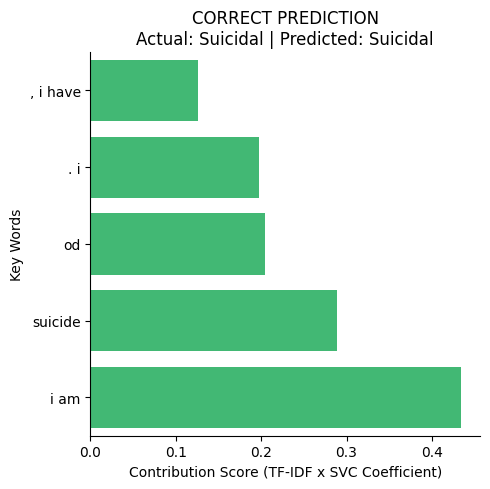


[WRONG PREDICTION] Random Text snippet: day 2 365i am here voice out what inside my mind , because i really have no one tell . i have been suffering depressing thought almost two decade now only way i can vent out . i hope you guy find solace . eerie feeling numbness crawl through my stomach very bone my spine . i might not depressed not having panic attack a pain i have never really got used . alone again my thought a i try shut my eye from hellscape my mind . day 2 365...


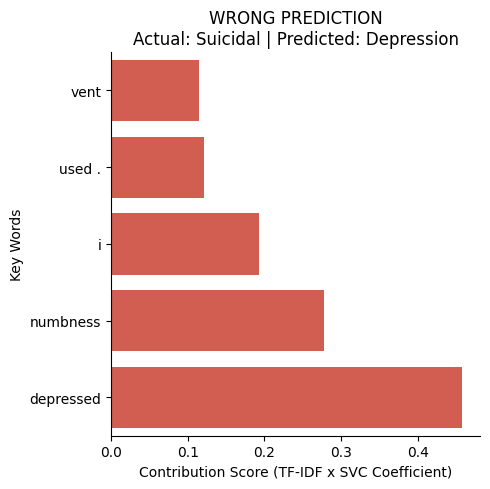

In [ ]:
def plot_local_importance(pipeline, text, actual_label, pred_label, sample_type):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    x_vec = tfidf.transform([text])
    class_labels = list(svc.classes_)
    pred_idx = class_labels.index(pred_label)

    x_dense = x_vec.toarray()[0]
    weights = svc.coef_[pred_idx]
    if hasattr(weights, "toarray"):
        weights = weights.toarray()[0]
    else:
        weights = weights.flatten()

    # 3. Calculate importance
    importance = x_dense * weights
    feature_names = tfidf.get_feature_names_out()
    indices = np.argsort(importance)[-5:]
    plot_indices = [i for i in indices if importance[i] > 0]

    if not plot_indices:
        print(f"No positive contributing features found for this {sample_type}.")
        return

    values = importance[plot_indices]
    names = feature_names[plot_indices]

    plt.figure(figsize=(5, 5))
    color = "#2ecc71" if "CORRECT" in sample_type else "#e74c3c"

    sns.barplot(x=values, y=names, color=color)
    plt.title(
        f"{sample_type}\nActual: {actual_label} | Predicted: {pred_label}", fontsize=12
    )
    plt.xlabel("Contribution Score (TF-IDF x SVC Coefficient)", fontsize=10)
    plt.ylabel("Key Words", fontsize=10)
    sns.despine()
    plt.tight_layout()
    plt.show()


def analyze_visual_random(pipeline, X_val, y_val):
    y_pred = pipeline.predict(X_val)
    results = pd.DataFrame({"text": X_val, "actual": y_val, "pred": y_pred})
    classes = sorted(results["actual"].unique())

    for cls in classes:
        print("\n" + "=" * 60)
        print(f" CLASS: {cls}")
        print("=" * 60)

        correct_pool = results[(results["actual"] == cls) & (results["pred"] == cls)]
        wrong_pool = results[(results["actual"] == cls) & (results["pred"] != cls)]

        samples = [
            ("CORRECT PREDICTION", correct_pool),
            ("WRONG PREDICTION", wrong_pool),
        ]

        for label, pool in samples:
            if pool.empty:
                continue

            # Select a random sample from the pool
            data = pool.sample(n=1).iloc[0]

            text_val = data["text"]
            actual_val = data["actual"]
            pred_val = data["pred"]

            print(f"\n[{label}] Random Text snippet: {text_val}...")
            plot_local_importance(pipeline, text_val, actual_val, pred_val, label)


analyze_visual_random(svc_pipeline, X_test, y_test)

In [ ]:
svc_pipeline = joblib.load("./svc_pipeline.pkl")

Analyzing Importance for: Depression


/tmp/ipykernel_21590/2748679422.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


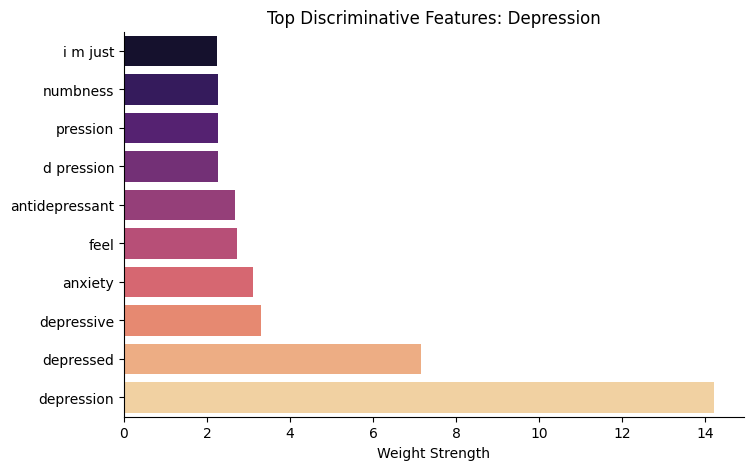

Analyzing Importance for: Normal


/tmp/ipykernel_21590/2748679422.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


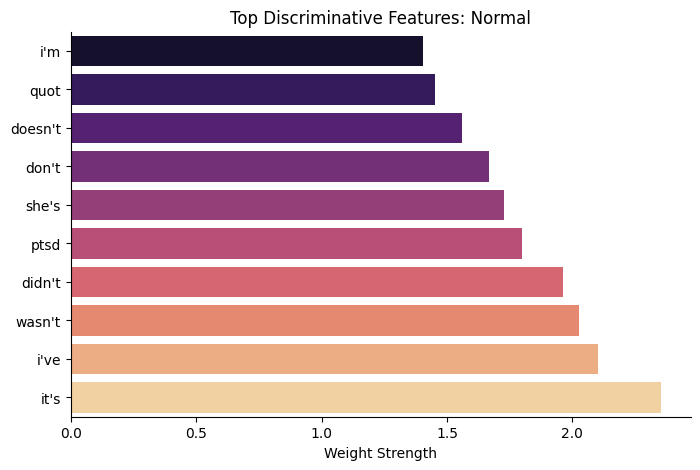

Analyzing Importance for: Suicidal


/tmp/ipykernel_21590/2748679422.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")


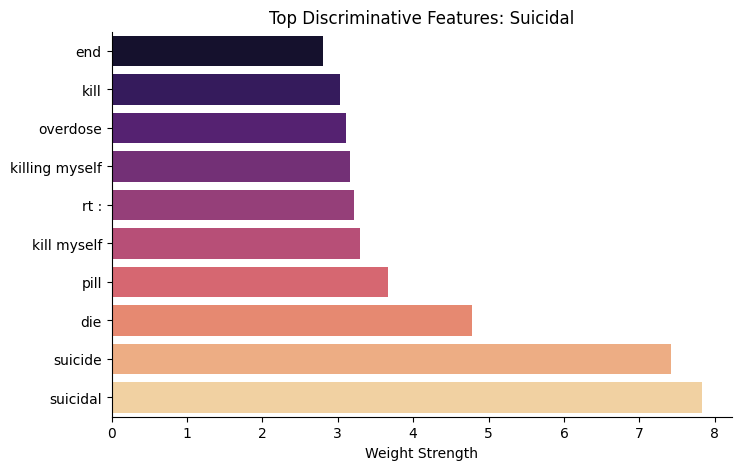

In [ ]:
def plot_linear_svc_importance(pipeline, target_class, top_n=10):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    feature_names = tfidf.get_feature_names_out()
    classes = list(svc.classes_)
    target_idx = classes.index(target_class)

    # LinearSVC coef_ is (n_classes, n_features) for multi-class
    # For binary, it's (1, n_features)
    if svc.coef_.shape[0] == 1:
        weights = svc.coef_[0] if target_idx == 1 else -svc.coef_[0]
    else:
        weights = svc.coef_[target_idx]

    # Get indices of the top N weights
    indices = np.argsort(weights)[-top_n:]

    # Validation: Filter out weights that are effectively zero or negative
    # This prevents 'leaked' features from other classes showing up
    plot_indices = [i for i in indices if weights[i] > 0]

    if not plot_indices:
        print(f"No positive features found for {target_class}")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")
    plt.title(f"Top Discriminative Features: {target_class}", fontsize=12)
    plt.xlabel("Weight Strength")
    sns.despine()
    plt.show()


# Loop through all available classes (Normal, Depression, Suicidal, etc.)
for cls in svc_pipeline.named_steps["svc"].classes_:
    print(f"Analyzing Importance for: {cls}")
    plot_linear_svc_importance(svc_pipeline, cls)